# DESI-347 Throughput Updates to DESIMODEL

Study changes to DESIMODEL after updating throughputs from [DESI-347](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=347).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import astropy.table

In [4]:
from desimodel.inputs import docdb
from desimodel.inputs.throughput import load_spec_throughputs

The code below assumes that `$DESIMODEL` has subdirectories `data.<VERSION>` where `<VERSION>` refers to DESI-347.

In [5]:
def compare(old='v13', new='v16'):
    old_data = os.path.join(os.getenv('DESIMODEL'), 'data.{0}'.format(old))
    new_data = os.path.join(os.getenv('DESIMODEL'), 'data.{0}'.format(new))
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))
    wlen, throughput, extinction, fiberinput = {}, {}, {}, {}    
    for band, color in zip('brz', 'brk'):
        for version, path, ls in zip((new, old), (new_data, old_data), ('-', ':')):
            label=f'{version}-{band}'
            table = astropy.table.Table.read(os.path.join(path, 'throughput', f'thru-{band}.fits'), hdu=1)
            wlen[label] = np.array(table['wavelength'])
            throughput[label] = np.asarray(table['throughput'])
            extinction[label] = np.asarray(table['extinction'])
            fiberinput[label] = np.asarray(table['fiberinput'])                                           
            ax[0].plot(wlen[label], throughput[label], ls=ls, c=color, label=label)
        # Check that only the throughput arrays have changed.
        assert np.array_equal(wlen[f'{old}-{band}'], wlen[f'{new}-{band}'])
        assert np.array_equal(extinction[f'{old}-{band}'], extinction[f'{new}-{band}'])
        assert np.array_equal(fiberinput[f'{old}-{band}'], fiberinput[f'{new}-{band}'])
        # Plot relative changes in throughput.
        rel = throughput[f'{new}-{band}'] / throughput[f'{old}-{band}']
        ax[1].plot(wlen[label], rel, color=color)
    # Print integrated throughput in each band.
    print('| version | b total | r total | z total |')
    print('|---------|---------|---------|---------|')
    for version in new, old:
        print(f'| {version:7s} ', end='')
        for band in 'brz':
            label=f'{version}-{band}'
            total = np.trapz(throughput[label], wlen[label])
            print(f'| {total:6.1f}A ', end='')
        print('|')
    ax[0].legend(ncol=3)
    ax[0].set_ylabel('Throughput')
    ax[1].set_ylabel(f'Relative Change {new}/{old}')
    ax[1].set_xlabel('Wavelength [A]')
    ax[1].set_ylim(0.7, 1.3)
    ax[1].axhline(1, ls='--', c='k')
    plt.tight_layout()
    plt.savefig(f'throughput-{new}-{old}.png')

| version | b total | r total | z total |
|---------|---------|---------|---------|
| v13     |  852.6A |  821.5A | 1022.2A |
| v12     |  872.0A |  846.2A | 1062.9A |


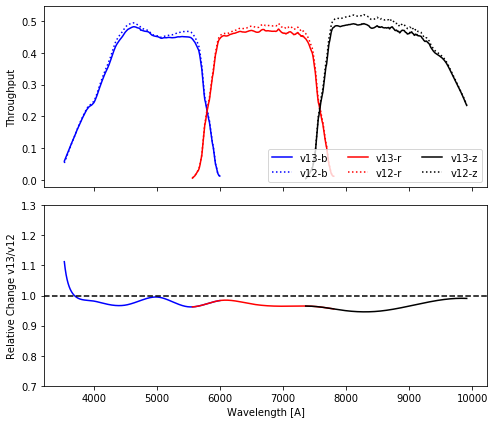

In [6]:
compare('v12', 'v13')

| version | b total | r total | z total |
|---------|---------|---------|---------|
| v16     |  706.6A |  743.3A | 1050.2A |
| v13     |  852.6A |  821.5A | 1022.2A |


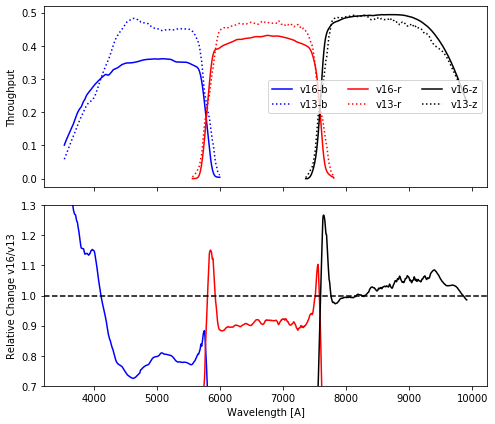

In [7]:
compare('v13', 'v16')

Plot the latest per-spectrograph throughputs and compare with the requirements and DESI-0347 coarse grid values:

INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spectrograph1KOSI.xlsx already exists; use overwrite=True to force redownload
INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spectrograph2KOSI.xlsx already exists; use overwrite=True to force redownload
INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spectrograph3KOSI.xlsx already exists; use overwrite=True to force redownload
INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spectrograph4KOSI.xlsx already exists; use overwrite=True to force redownload
INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spectrograph5KOSI.xlsx already exists; use overwrite=True to force redownload
INFO:docdb.py:123:download: /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/docdb/DESI-5501v3-Spec

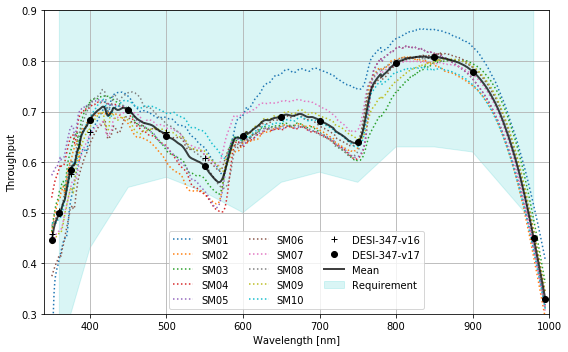

In [8]:
def plot_spectro_thru(desi5501_version=3, desi5501_KOSI=True):
    
    ccd_thru_file = []
    suffix = 'KOSI' if desi5501_KOSI else ''
    for spectro in range(10):
        ccd_thru_file.append(docdb.download(
            5501, desi5501_version, 'Spectrograph{0}{1}.xlsx'.format(spectro + 1, suffix)))
        
    wave, thru = load_spec_throughputs(ccd_thru_file)    
    
    # Average throughput from row 95 of the Throughput spreadsheet in DESI-0347-v16.
    wave_avg = [  350,  360,  375,  400,  450,  500,  550,  600,  650,  700,  750,  800,  850,  900,  980,  995]
    thru_avg_v16 = [0.457,0.503,0.577,0.660,0.705,0.660,0.609,0.652,0.690,0.682,0.639,0.796,0.808,0.779,0.449,0.330]
    
    # Update for v17 proposed by Pat Jelinsky (16-Apr-2020)
    thru_avg_v17 = [0.445,0.500,0.585,0.683,0.704,0.652,0.592,0.652,0.690,0.682,0.640,0.796,0.808,0.779,0.449,0.330]
    
    # Throughput requirement from IN.SPEC-6004 in DESI-0613.
    wave_req = [360,  375,  400,  450,  500,  550,  600,  650,  700,  750,  800,  850,  900,  980]
    thru_req = [0.21, 0.3, 0.43, 0.55, 0.57, 0.54, 0.50, 0.56, 0.58, 0.56, 0.63, 0.63, 0.62, 0.48]
    
    fig = plt.figure(figsize=(8, 5))
    #thru_to_avg = []
    for spectro in range(10):
        thru_total = thru[spectro].sum(axis=0)
        plt.plot(wave, thru_total, ':', label='SM{0:02d}'.format(spectro + 1))
        # Interpolate the total throughput onto the wavelength grid used for the average in DESI-347.
        #thru_to_avg.append(np.interp(wave_avg, wave, thru_total))
        
    plt.fill_between(wave_req, thru_req, 1, color='c', alpha=0.15, lw=1, label='Requirement')
    plt.plot(wave_avg, thru_avg_v16, 'k+', label='DESI-347-v16')
    plt.plot(wave_avg, thru_avg_v17, 'ko', label='DESI-347-v17')
    plt.plot(wave, np.mean(thru.sum(axis=1), axis=0), 'k-', lw=2, alpha=0.75, label='Mean')
    #plt.plot(wave, np.median(thru.sum(axis=1), axis=0), 'r-', lw=1, label='Median')
    
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Throughput')
    plt.ylim(0.3, 0.9)
    plt.xlim(340, 1000)
    plt.legend(ncol=3, loc='lower center')
    plt.grid()
    plt.tight_layout()
    plt.savefig('spectro_thru.png')

plot_spectro_thru()